<a href="https://colab.research.google.com/github/Marvin2798/CNN-Project-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Link : https://github.com/ironhack-labs/project-1-deep-learning-image-classification-with-cnn/blob/main/README.md#project-i--deep-learning-image-classification-with-cnn

1. Loading and Data Processing

In [34]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [35]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train
X_test


array([[[[0.61960787, 0.4392157 , 0.19215687],
         [0.62352943, 0.43529412, 0.18431373],
         [0.64705884, 0.45490196, 0.2       ],
         ...,
         [0.5372549 , 0.37254903, 0.14117648],
         [0.49411765, 0.35686275, 0.14117648],
         [0.45490196, 0.33333334, 0.12941177]],

        [[0.59607846, 0.4392157 , 0.2       ],
         [0.5921569 , 0.43137255, 0.15686275],
         [0.62352943, 0.44705883, 0.1764706 ],
         ...,
         [0.53333336, 0.37254903, 0.12156863],
         [0.49019608, 0.35686275, 0.1254902 ],
         [0.46666667, 0.34509805, 0.13333334]],

        [[0.5921569 , 0.43137255, 0.18431373],
         [0.5921569 , 0.42745098, 0.12941177],
         [0.61960787, 0.43529412, 0.14117648],
         ...,
         [0.54509807, 0.38431373, 0.13333334],
         [0.50980395, 0.37254903, 0.13333334],
         [0.47058824, 0.34901962, 0.12941177]],

        ...,

        [[0.26666668, 0.4862745 , 0.69411767],
         [0.16470589, 0.39215687, 0.5803922 ]

In [36]:
# Import to_categorical
from tensorflow.keras.utils import to_categorical  # Import to_categorical

In [37]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [38]:
#datagen = ImageDataGenerator(
 #   rotation_range=15,
  #  width_shift_range=0.1,
   # height_shift_range=0.1,
    #horizontal_flip=True,
#)
#datagen.fit(X_train)

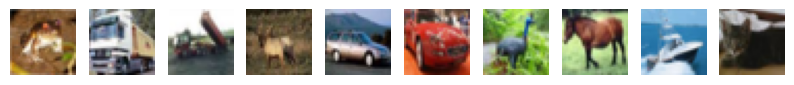

In [39]:
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()


In [40]:
#

2. Model Architecture

In [41]:
# from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
#model = Sequential()
#added data augmentation layers
#model.add(RandomFlip("horizontal", input_shape=(32, 32, 3))) # input_shape is specified here
#model.add(RandomRotation(0.2))

# Add convolutional layers and pooling layers
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
#model.add(Flatten())

# Add fully connected (dense) layers
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))  # Dropout to avoid overfitting
#model.add(Dense(10, activation='softmax'))  # Output layer (10 classes)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast  # Removed RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Define the model with enhanced data augmentation
model = Sequential()

# Data augmentation layers
model.add(RandomFlip("horizontal", input_shape=(32, 32, 3)))
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.2))
model.add(RandomContrast(0.2))

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10, activation='softmax'))


In [43]:
from tensorflow.keras.optimizers import SGD
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    #optimizer='adam',changed the optimizer to sgd to speed up the model training.
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy']
)


In [44]:
# Display the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_5 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 32, 32, 3)         0         
                                                                 
 random_contrast_1 (RandomC  (None, 32, 32, 3)         0         
 ontrast)                                                        
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)       

3. Model Training

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=25 , batch_size=32,#reduced epoch to 25 from 50 to speed up the training
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/25
1563/1563 [==============================] - 54s 33ms/step - loss: 2.1455 - accuracy: 0.2097 - val_loss: 1.9091 - val_accuracy: 0.3043
Epoch 2/25
1563/1563 [==============================] - 52s 33ms/step - loss: 1.9890 - accuracy: 0.2671 - val_loss: 2.0277 - val_accuracy: 0.2130
Epoch 3/25
1563/1563 [==============================] - 52s 33ms/step - loss: 1.9325 - accuracy: 0.2963 - val_loss: 1.7320 - val_accuracy: 0.3793
Epoch 4/25
1563/1563 [==============================] - 52s 33ms/step - loss: 1.8871 - accuracy: 0.3161 - val_loss: 1.8214 - val_accuracy: 0.3233
Epoch 5/25
1563/1563 [==============================] - 51s 33ms/step - loss: 1.8365 - accuracy: 0.3360 - val_loss: 1.8306 - val_accuracy: 0.2963
Epoch 6/25
1563/1563 [==============================] - 53s 34ms/step - loss: 1.7982 - accuracy: 0.3473 - val_loss: 1.6684 - val_accuracy: 0.4012
Epoch 7/25
1563/1563 [==============================] - 52s 33ms/step - loss: 1.7633 - accuracy: 0.3625 - val_loss: 1.5439 -


  4. Model Evaluation



In [49]:
# Corrected code to fix the model evaluation
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


313/313 [==============================] - 2s 7ms/step - loss: 1.1933 - accuracy: 0.5588
Validation Loss: 1.1933345794677734
Validation Accuracy: 0.5587999820709229


In [50]:
# Evaluate the model on the validation set
#val_loss, val_accuracy = model.evaluate(x_val, y_val)
#print(f'Validation Loss: {val_loss}')
#print(f'Validation Accuracy: {val_accuracy}')



In [52]:
from sklearn.metrics import classification_report

# Predict the labels on the validation set
#y_pred = model.predict(x_val)
#y_pred_classes = y_pred.argmax(axis=1)  # Get the predicted class indices
#y_true = y_val.argmax(axis=1)  # Get the true class indices if one-hot encoded

# Print the classification report
#print(classification_report(y_true, y_pred_classes))


In [53]:
#corrected prediction
from sklearn.metrics import classification_report

# Predict the labels on the validation set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes))


313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.67      0.58      0.62      1000
           1       0.69      0.60      0.64      1000
           2       0.69      0.23      0.34      1000
           3       0.44      0.24      0.31      1000
           4       0.52      0.43      0.47      1000
           5       0.72      0.28      0.40      1000
           6       0.38      0.92      0.53      1000
           7       0.66      0.69      0.68      1000
           8       0.62      0.85      0.72      1000
           9       0.58      0.76      0.66      1000

    accuracy                           0.56     10000
   macro avg       0.60      0.56      0.54     10000
weighted avg       0.60      0.56      0.54     10000



In [55]:
#from sklearn.metrics import confusion_matrix
#import seaborn as sns
#import matplotlib.pyplot as plt

# Generate the confusion matrix
#cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
#plt.figure(figsize=(10, 8))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

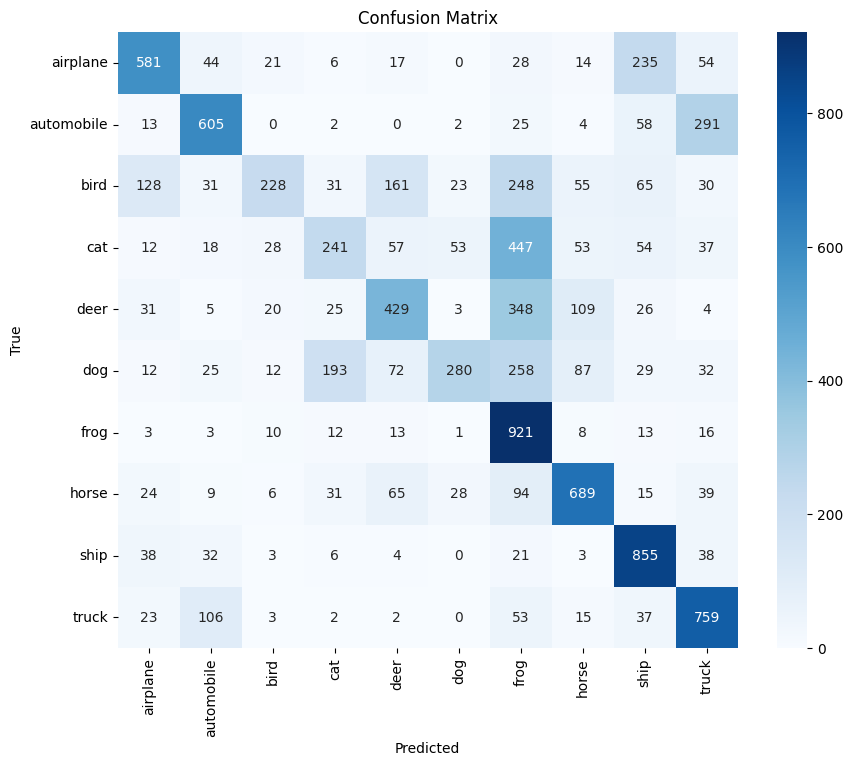

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Transfer Learning

In [58]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Load the VGG16 model without the top layers, customized for CIFAR-10 input size
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# new layers added to VGG16 for transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Final model for transfer learning
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# to freeze the base model layers before compiling to keep their weights fixed
for layer in base_model.layers:
    layer.trainable = False

#compiling the model
transfer_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Training the transfer learning model
transfer_history = transfer_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      validation_data=(X_test, y_test),
                                      epochs=20,
                                      callbacks=[early_stopping])



Epoch 1/20
1563/1563 [==============================] - 75s 47ms/step - loss: 1.9870 - accuracy: 0.2816 - val_loss: 1.6644 - val_accuracy: 0.4320
Epoch 2/20
1563/1563 [==============================] - 72s 46ms/step - loss: 1.7267 - accuracy: 0.3885 - val_loss: 1.5457 - val_accuracy: 0.4674
Epoch 3/20
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6405 - accuracy: 0.4211 - val_loss: 1.4785 - val_accuracy: 0.4800
Epoch 4/20
1563/1563 [==============================] - 72s 46ms/step - loss: 1.5968 - accuracy: 0.4353 - val_loss: 1.4280 - val_accuracy: 0.5007
Epoch 5/20
1563/1563 [==============================] - 72s 46ms/step - loss: 1.5656 - accuracy: 0.4477 - val_loss: 1.3998 - val_accuracy: 0.5091
Epoch 6/20
1563/1563 [==============================] - 73s 46ms/step - loss: 1.5429 - accuracy: 0.4555 - val_loss: 1.3799 - val_accuracy: 0.5186
Epoch 7/20
1563/1563 [==============================] - 73s 47ms/step - loss: 1.5206 - accuracy: 0.4640 - val_loss: 1.3598 -

Fine-tuning to help the model adapt the pre-trained knowledge to ours

In [59]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
transfer_model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Continue training the model for fine-tuning
fine_tune_history = transfer_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                                       validation_data=(X_test, y_test),
                                       epochs=10,
                                       callbacks=[early_stopping])


Epoch 1/10
1563/1563 [==============================] - 131s 83ms/step - loss: 1.3388 - accuracy: 0.5291 - val_loss: 1.1667 - val_accuracy: 0.5885
Epoch 2/10
1563/1563 [==============================] - 131s 84ms/step - loss: 1.2801 - accuracy: 0.5545 - val_loss: 1.1324 - val_accuracy: 0.6033
Epoch 3/10
1563/1563 [==============================] - 131s 84ms/step - loss: 1.2435 - accuracy: 0.5665 - val_loss: 1.0952 - val_accuracy: 0.6148
Epoch 4/10
1563/1563 [==============================] - 131s 84ms/step - loss: 1.2186 - accuracy: 0.5756 - val_loss: 1.0649 - val_accuracy: 0.6249
Epoch 5/10
1563/1563 [==============================] - 132s 85ms/step - loss: 1.1892 - accuracy: 0.5836 - val_loss: 1.0469 - val_accuracy: 0.6328
Epoch 6/10
1563/1563 [==============================] - 130s 83ms/step - loss: 1.1759 - accuracy: 0.5879 - val_loss: 1.0379 - val_accuracy: 0.6339
Epoch 7/10
1563/1563 [==============================] - 130s 83ms/step - loss: 1.1589 - accuracy: 0.5951 - val_loss: 1

In [60]:
from sklearn.metrics import classification_report

# Predict the labels on the test set
y_pred_fine_tuned = transfer_model.predict(X_test)
y_pred_classes_fine_tuned = y_pred_fine_tuned.argmax(axis=1)  # Get the predicted class indices
y_true = y_test.argmax(axis=1)  # Get the true class indices if one-hot encoded

# Print the classification report
print("Fine-Tuned Model Classification Report:")
print(classification_report(y_true, y_pred_classes_fine_tuned, target_names=class_names))


313/313 [==============================] - 12s 37ms/step
Fine-Tuned Model Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.71      0.73      1000
  automobile       0.69      0.80      0.74      1000
        bird       0.59      0.52      0.55      1000
         cat       0.53      0.40      0.46      1000
        deer       0.62      0.52      0.57      1000
         dog       0.62      0.52      0.56      1000
        frog       0.54      0.83      0.65      1000
       horse       0.71      0.74      0.72      1000
        ship       0.80      0.74      0.77      1000
       truck       0.70      0.73      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



Plotting history before and after fine-tuning

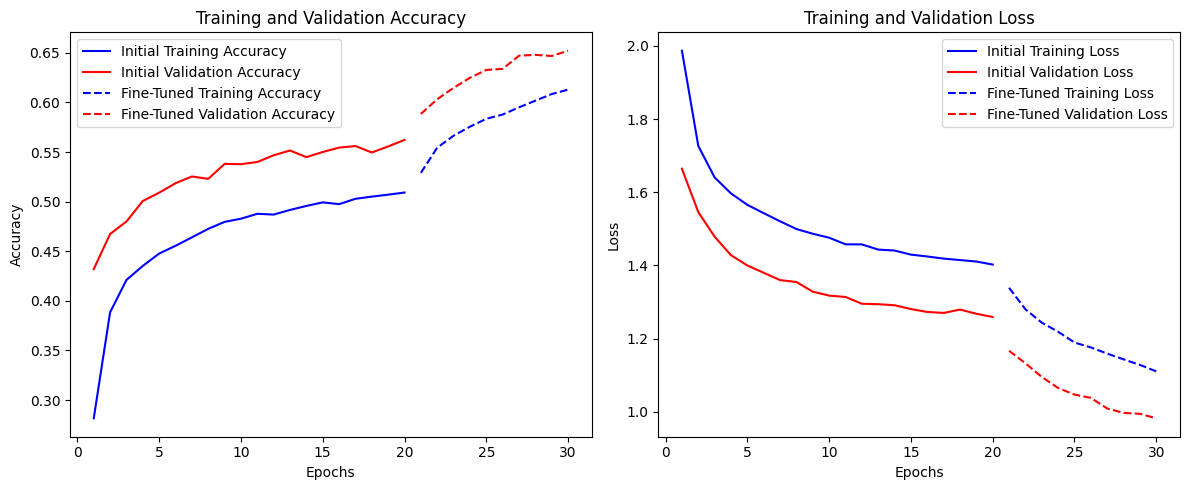

In [63]:
import matplotlib.pyplot as plt

def plot_training_history(initial_history, fine_tune_history):
    # Combine training and validation metrics from both training stages
    acc = initial_history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = initial_history.history['loss'] + fine_tune_history.history['loss']
    val_loss = initial_history.history['val_loss'] + fine_tune_history.history['val_loss']

    epochs_initial = range(1, len(initial_history.history['accuracy']) + 1)
    epochs_fine_tune = range(len(initial_history.history['accuracy']) + 1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_initial, initial_history.history['accuracy'], 'b-', label='Initial Training Accuracy')
    plt.plot(epochs_initial, initial_history.history['val_accuracy'], 'r-', label='Initial Validation Accuracy')
    plt.plot(epochs_fine_tune, fine_tune_history.history['accuracy'], 'b--', label='Fine-Tuned Training Accuracy')
    plt.plot(epochs_fine_tune, fine_tune_history.history['val_accuracy'], 'r--', label='Fine-Tuned Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_initial, initial_history.history['loss'], 'b-', label='Initial Training Loss')
    plt.plot(epochs_initial, initial_history.history['val_loss'], 'r-', label='Initial Validation Loss')
    plt.plot(epochs_fine_tune, fine_tune_history.history['loss'], 'b--', label='Fine-Tuned Training Loss')
    plt.plot(epochs_fine_tune, fine_tune_history.history['val_loss'], 'r--', label='Fine-Tuned Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the initial training history and fine-tuning history
plot_training_history(transfer_history, fine_tune_history)



Comparing Confusion Matrices Before and After Fine-Tuning

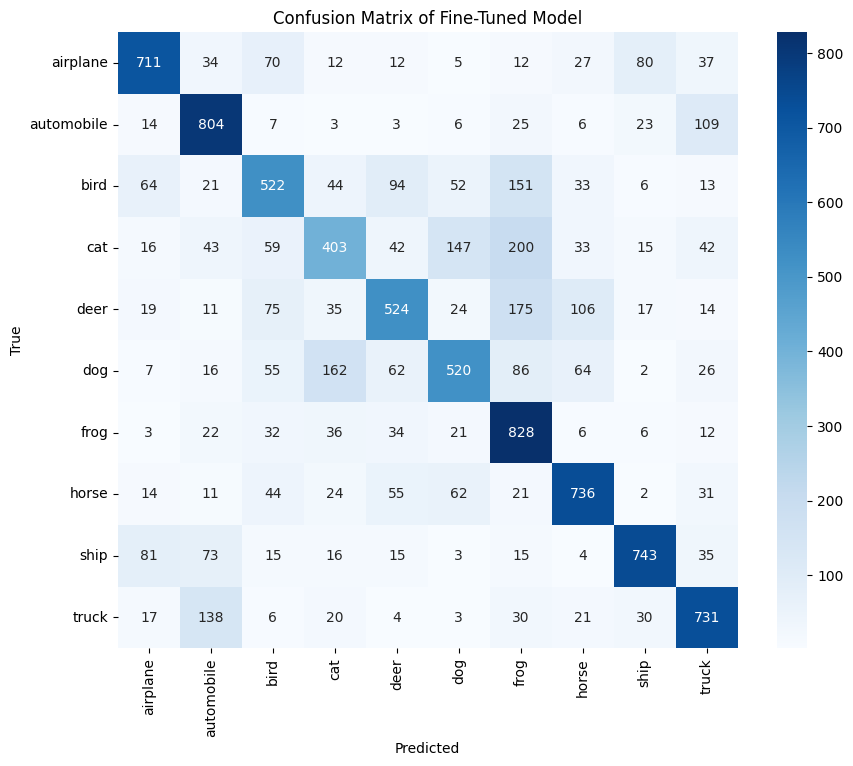

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix for the fine-tuned model
cm_fine_tuned = confusion_matrix(y_true, y_pred_classes_fine_tuned)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fine_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Fine-Tuned Model')
plt.show()


Saving the Trained Model in  the TensorFlow SavedModel format:

In [ ]:
#prep code for deployment to be uncommented as the last step
#next line saves thetransfer learning model in the SavedModel format
##transfer_model.save

##from google.colab import files
##!zip -r my_best_model.zip /content/my_best_model
##files.download('my_best_model.zip')

